<a href="https://colab.research.google.com/github/qazqaz5556/asd/blob/main/3d_sketch_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from time import time
import numpy as np
from itertools import count
from sklearn.metrics import auc as auc_metric

def RetrievalEvaluation(distM, model_label, sketch_label):
    '''
    ## INPUT:
    distM: distance matrix
    model_label: class labels for 3D model
    sketch_label: class labels for 2D sketches

    ##OUTPUT:
    metrics: NN, FT, ST, DCG, E, mAP, pre, rec, auc
    record for visualization (ignored): rankArray
    '''
    distM=distM
    C_sketch = np.zeros((len(sketch_label)), dtype="int32")
    for i in range(len(sketch_label)):
        C_sketch[i] = np.sum(model_label == sketch_label[i])
    C = C_sketch
    recall = np.zeros((distM.shape[0], distM.shape[1]))
    precision = np.zeros((distM.shape[0], distM.shape[1]))
    rankArray = np.zeros((distM.shape[0], distM.shape[1]))

    nb_of_query = C.shape[0]
    p_points = np.zeros((nb_of_query, np.amax(C)))
    ap = np.zeros(nb_of_query)
    nn = np.zeros(nb_of_query)
    ft = np.zeros(nb_of_query)
    st = np.zeros(nb_of_query)
    dcg = np.zeros(nb_of_query)
    e_measure = np.zeros(nb_of_query)

    for qqq in range(nb_of_query):
        temp_dist = np.array(distM[qqq])
        temp_dist = np.squeeze(temp_dist)
        s = list(temp_dist)
        R = sorted(range(len(s)), key=lambda k: s[k])

        model_label_l = model_label[R]
        numRetrieval = distM.shape[1]
        G = np.zeros(numRetrieval)
        rankArray[qqq] = R

        model_label_l = np.squeeze(model_label_l)
        for i in range(numRetrieval):
            if model_label_l[i] == sketch_label[qqq]:
                G[i] = 1
        G_sum = np.cumsum(G)
        r1 = G_sum / float(C[qqq])
        p1 = G_sum / np.arange(1, numRetrieval+1)
        r_points = np.zeros(C[qqq])
        for i in range(C[qqq]):
            temp = np.where(G_sum == i+1)
            r_points[i] = np.where(G_sum == (i+1))[0][0] + 1
        r_points_int = np.array(r_points, dtype=int)

        p_points[qqq][:int(C[qqq])] = G_sum[r_points_int-1] / r_points
        ap[qqq] = np.mean(p_points[qqq][:int(C[qqq])])
        nn[qqq] = G[0]
        ft[qqq] = G_sum[C[qqq]-1] / C[qqq]
        st[qqq] = G_sum[min(2*C[qqq]-1, G_sum.size-1)] / C[qqq]
        p_32 = G_sum[min(31, G_sum.size-1)] / min(32, G_sum.size)
        r_32 = G_sum[min(31, G_sum.size-1)] / C[qqq]
        if p_32 == 0 and r_32 == 0:
            e_measure[qqq] = 0
        else:
            e_measure[qqq] = 2* p_32 * r_32/(p_32+r_32)

        NORM_VALUE = 1 + np.sum(1/np.log2(np.arange(2,C[qqq]+1)))
        dcg_i = 1/np.log2(np.arange(2, len(R)+1)) * G[1:]
        dcg_i = np.insert(dcg_i, 0, G[0])
        dcg[qqq] = np.sum(dcg_i, axis=0)/NORM_VALUE
        recall[qqq] = r1
        precision[qqq] = p1


    nn_av = np.mean(nn)
    ft_av = np.mean(ft)
    st_av = np.mean(st)
    dcg_av = np.mean(dcg)
    e_av = np.mean(e_measure)
    map_ = np.mean(ap)

    pre = np.mean(precision, axis=0)
    rec = np.mean(recall, axis=0)
    auc = auc_metric(rec, pre)

    return nn_av, ft_av, st_av, dcg_av, e_av, map_, p_points, pre, rec, auc, rankArray

In [ ]:
# Task1: CAD, Task2: Wild
distM_filenames = [
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_2_CCZU/submission/Task 1/resultT1_1.npy',
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_2_CCZU/submission/Task 1/resultT1_2.npy',
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_2_CCZU/submission/Task 1/resultT1_3.npy',
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_3_HCMUS_Team2/submission/Task_1_v2/Run1-PointNet.npy',
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_3_HCMUS_Team2/submission/Task_1_v2/Run2-PointNetKFold.npy',
  '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_4_HIT/submission/Task 1/task1.npy',
]
for distM_filename in distM_filenames:
  task_type = distM_filename.split('submission/Task')[-1].split('/')[0].split('v')[0]
  if '1' in task_type:
    gt_type = 'CAD'
  else:
    gt_type = 'WILD'

  save_dir = distM_filename.split('/submission')[0].replace('evaluation/', 'evaluation_check/')
  distM_file = '{}'.format(distM_filename)
  distM_filename = distM_filename.split('submission/')[-1].replace('/', '--')[:-4]
  try:
    distM = np.load(distM_file)
  except:
    distM = np.loadtxt(distM_file)

  lbl_model = np.loadtxt('/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/{}_gt.npy'.format(gt_type))
  lbl_sketch = np.loadtxt('/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/{}_sketch_gt.npy'.format(gt_type))
  print('distM.shape:', distM.shape)
  print('lbl_model.shape:', lbl_model.shape)
  print('lbl_sketch.shape:', lbl_sketch.shape)


  time_st = time()

  nn_av, ft_av, st_av, dcg_av, e_av, map_, p_points, pre, rec, auc, rankArray = RetrievalEvaluation(distM, lbl_model, lbl_sketch)

  info_1 = 'distM_file: {}\ntime consuming: {}s.\n'.format(distM_file, time() - time_st)
  info_2 = 'nn_av: {}\nft_av: {}\nst_av: {}\ndcg_av: {}\ne_av: {}\nmap_: {}\n'.format(nn_av, ft_av, st_av, dcg_av, e_av, map_)
  info_3 = 'auc: {}\n'.format(auc)
  print(info_1)
  print(info_2)
  print('p_points:\n', p_points)
  print('pre:\n', pre)
  print('rec:\n', rec)
  print(info_3)
  print('rankArray:\n', rankArray)
  print()
  if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
  with open(os.path.join(save_dir, '{}_output.txt').format(distM_filename), 'w') as f:
    f.write(info_1 + info_2 + info_3 + '\n')
  np.savetxt(os.path.join(save_dir, '{}_pre.txt'.format(distM_filename)), pre)
  np.savetxt(os.path.join(save_dir, '{}_rec.txt'.format(distM_filename)), rec)
  if gt_type == 'WILD':
    np.save(os.path.join(save_dir, '{}_p_points.npy'.format(distM_filename)), p_points)
    np.save(os.path.join(save_dir, '{}_rankArray.npy'.format(distM_filename)), rankArray)
  else:
    np.save(os.path.join(save_dir, '{}_p_points.npy'.format(distM_filename)), p_points)
    np.save(os.path.join(save_dir, '{}_rankArray.npy'.format(distM_filename)), rankArray)

distM.shape: (23992, 12000)
lbl_model.shape: (12000,)
lbl_sketch.shape: (23992,)
distM_file: /content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation/team_4_HIT/submission/Task 1/task1.npy
time consuming: 351.3757801055908s.

nn_av: 0.010795265088362788
ft_av: 0.015414028092297699
st_av: 0.03098713202612801
dcg_av: 0.3628591862434631
e_av: 0.0010532518669274613
map_: 0.020477612465387533

p_points:
 [[1.34770889e-03 1.60000000e-03 2.04081633e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 6.66666667e-01 5.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.11111111e-02 7.40740741e-03 8.02139037e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [5.40540541e-04 8.05801773e-04 6.82438581e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.02938503e-04 5.43478261e-04 5.71210967e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.87401575e-04 9.57854406e-04 1.20385233e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+

In [ ]:
# Task1: CAD, Task2: Wild
distM_filenames = [
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/team_2_pc/submission/Task 2/dist_pc.npz',
  # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/submission/Task 1/dist_cad_mv.npy',
  '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/submission/Task 1/dist_cad_pc.npy',
]
for distM_filename in distM_filenames:
  task_type = distM_filename.split('submission/Task')[-1].split('/')[0].split('v')[0]
  if '1' in task_type:
    gt_type = 'CAD'
  else:
    gt_type = 'WILD'

  save_dir = distM_filename.split('/submission')[0].replace('evaluation/', 'evaluation_check/')
  distM_file = '{}'.format(distM_filename)
  distM_filename = distM_filename.split('submission/')[-1].replace('/', '--')[:-4]
  try:
    distM = np.load(distM_file)
  except:
    distM = np.loadtxt(distM_file)

  lbl_model = np.loadtxt('/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/{}_gt.npy'.format(gt_type))
  lbl_sketch = np.loadtxt('/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/{}_sketch_gt.npy'.format(gt_type))
  print('distM.shape:', distM.shape)
  print('lbl_model.shape:', lbl_model.shape)
  print('lbl_sketch.shape:', lbl_sketch.shape)


  time_st = time()

  nn_av, ft_av, st_av, dcg_av, e_av, map_, p_points, pre, rec, auc, rankArray = RetrievalEvaluation(distM, lbl_model, lbl_sketch)

  info_1 = 'distM_file: {}\ntime consuming: {}s.\n'.format(distM_file, time() - time_st)
  info_2 = 'nn_av: {}\nft_av: {}\nst_av: {}\ndcg_av: {}\ne_av: {}\nmap_: {}\n'.format(nn_av, ft_av, st_av, dcg_av, e_av, map_)
  info_3 = 'auc: {}\n'.format(auc)
  print(info_1)
  print(info_2)
  print('p_points:\n', p_points)
  print('pre:\n', pre)
  print('rec:\n', rec)
  print(info_3)
  print('rankArray:\n', rankArray)
  print()
  if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)
  with open(os.path.join(save_dir, '{}_output.txt').format(distM_filename), 'w') as f:
    f.write(info_1 + info_2 + info_3 + '\n')
  np.savetxt(os.path.join(save_dir, '{}_pre.txt'.format(distM_filename)), pre)
  np.savetxt(os.path.join(save_dir, '{}_rec.txt'.format(distM_filename)), rec)
  if gt_type == 'WILD':
    np.save(os.path.join(save_dir, '{}_p_points.npy'.format(distM_filename)), p_points)
    np.save(os.path.join(save_dir, '{}_rankArray.npy'.format(distM_filename)), rankArray)
  else:
    np.save(os.path.join(save_dir, '{}_p_points.npy'.format(distM_filename)), p_points)
    np.save(os.path.join(save_dir, '{}_rankArray.npy'.format(distM_filename)), rankArray)

distM.shape: (23992, 12000)
lbl_model.shape: (12000,)
lbl_sketch.shape: (23992,)
distM_file: /content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/submission/Task 1/dist_cad_pc.npy
time consuming: 450.314980506897s.

nn_av: 0.01646382127375792
ft_av: 0.018524813763834722
st_av: 0.040366609505128076
dcg_av: 0.3789864100584074
e_av: 0.00325630694848363
map_: 0.020125265130394435

p_points:
 [[0.00097847 0.00118203 0.00174723 ... 0.         0.         0.        ]
 [0.33333333 0.22222222 0.1875     ... 0.         0.         0.        ]
 [0.07692308 0.14285714 0.03797468 ... 0.         0.         0.        ]
 ...
 [0.00769231 0.01104972 0.00961538 ... 0.         0.         0.        ]
 [0.0106383  0.00328407 0.003386   ... 0.         0.         0.        ]
 [0.00129199 0.0025641  0.00114504 ... 0.         0.         0.        ]]
pre:
 [0.01646382 0.01362954 0.01554685 ... 0.01949194 0.01949274 0.01949249]
rec:
 [7.08121345e-06 1.26400523e-05 2.83589984e-05 ... 9.99902688e-01
 9.

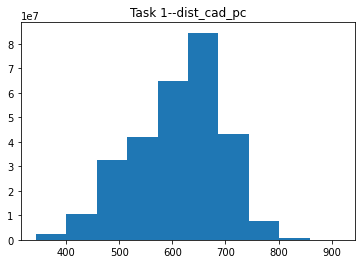

[[661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]
 [661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]
 [661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]
 ...
 [661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]
 [661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]
 [661.30521171 674.58089649 701.44631766 ... 671.16011348 610.2713593
  621.51658683]]
np.mean(distM): 610.8459543923993
np.median(distM): 623.8316600309759


In [ ]:
import matplotlib.pyplot as plt


distM_filename = '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/team_2_pc/submission/Task 2/dist_pc.npz'
try:
  distM = np.load(distM_filename)
except:
  distM = np.loadtxt(distM_filename)
plt.hist(distM.ravel())
plt.title(distM_filename.split('evaluation/')[-1])
plt.show()
print(distM)
print('np.mean(distM):', np.mean(distM))
print('np.median(distM):', np.median(distM))

In [ ]:
import numpy as np


def read_pr(path_p):
  p = np.loadtxt(path_p).squeeze().tolist()
  r = np.loadtxt(path_p.replace('_pre.', '_rec.')).squeeze().tolist()
  pr_lst = np.array(sorted([[v[0], v[1]] for v in zip(p, r)], key=lambda x: x[1]))
  p = pr_lst[:, 0].tolist()
  r = pr_lst[:, 1].tolist()
  pr_lst = []
  x_index = [(x_idx / 100.) for x_idx in range(5, 101, 5)] + [1e5]
  
  idx_x_index = 0
  for idx_v, pr_v in enumerate(zip(p, r)):
    if idx_v+1 < len(p) and r[idx_v+1] >= x_index[idx_x_index]:
      pr_lst.append([pr_v[0], pr_v[1]])
      idx_x_index += 1
  pr = np.array(pr_lst)
  return pr

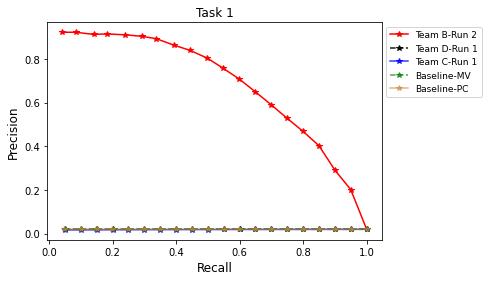

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter


task = 1
only_best = 1
if only_best:
  data_src = 'best'
else:
  data_src = 'all'

if task == 1:
  # Task 1
  if only_best:
    path_ps = [
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_1_v2--Run2-PointNetKFold_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 1--resultT1_1_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_C_HIT/Task 1--task1_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 1--dist_cad_mv_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/Task 1--dist_cad_pc_pre.txt',
    ]
    # Manually set
    only_best_run_indices = [2, 1, 1, 1, 1]
    only_best_run_idx = 0
  else:
    path_ps = [
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_1_v2--Run1-PointNet_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_1_v2--Run2-PointNetKFold_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_C_HIT/Task 1--task1_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 1--resultT1_1_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 1--resultT1_2_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 1--resultT1_3_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 1--dist_cad_mv_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/Task 1--dist_cad_pc_pre.txt',
    ]
else:
  # Task 2
  if only_best:
    path_ps = [
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_A_HCMUS_Team1/Task 2--run01_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_2_v2--Run4-PointNet-WILD_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_C_HIT/Task 2--task2_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 2--resultT2_1_pre.txt',
      ##########################
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 2--dist_mv_03_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/Task 2--dist_pc_pre.txt',
    ]
    # Manually set
    only_best_run_indices = [1, 4, 1, 1, 1, 1]
    only_best_run_idx = 0
  else:
    path_ps = [
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_A_HCMUS_Team1/Task 2--run01_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_2_v2--Run1-PointMLP_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_2_v2--Run2-PointNet_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_2_v2--Run3-PointNetKFold_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_B_HCMUS_Team2/Task_2_v2--Run4-PointNet-WILD_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_C_HIT/Task 2--task2_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 2--resultT2_1_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 2--resultT2_2_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/evaluation_check/team_D_CCZU/Task 2--resultT2_3_pre.txt',
      # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 2--dist_mv_pre.txt',
      # '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 2--dist_mv_02_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-MV/Task 2--dist_mv_03_pre.txt',
      '/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/Baseline-PC/Task 2--dist_pc_pre.txt',
    ]

pr = [read_pr(path_p) for path_p in path_ps]

x_index=['{}'.format(x_idx / 100) for x_idx in range(5, 101, 5)]
fs = 12
colors = [
  'red', 'black', 'blue', 'green', 'peru', 'magenta', 'yellow', 'purple', 'brown', 'cornflowerblue', 'lightpink', 'khaki', 'gold', 'orchid', 'lightsteelblue'
][:len(pr)]
markers = ['*' for _ in pr]
lines = ['-' if not (idx_t % 2) else '--' for idx_t in range(len(pr))]

labels_tbd = ['_'.join(path_p.split('/')[-2].split('_')[:2]) if 'baseline' not in path_p.lower() else path_p.split('/')[-2] for path_p in path_ps]
labels_cnt = dict(Counter(labels_tbd))
labels = []
for label in labels_tbd[::-1]:
  if only_best:
    if 'baseline' in label.lower():
      labels.append(label)
    else:
      labels.append(' '.join([lbl.capitalize() for lbl in label.split('_')]) + '-Run {}'.format(only_best_run_indices[::-1][only_best_run_idx]))
    only_best_run_idx += 1
  else:
    if 'baseline' in label.lower():
      labels.append(label)
    else:
      labels.append(' '.join([lbl.capitalize() for lbl in label.split('_')]) + '-Run {}'.format(labels_cnt[label]))
    labels_cnt[label] -= 1
labels = labels[::-1]
# with plt.style.context(['science', 'ieee']):
if 1:
  for i, p in enumerate(labels):
    alpha_value = max(0.3, 1 - i * 0.1) if pr[i][:, :1][0] < 0.2 else 1
    plt.plot(pr[i][:, 1], pr[i][:, 0], marker=markers[i], label=p, linestyle=lines[i], color=colors[i], alpha=alpha_value)
  plt.legend(fontsize=9, loc=2, bbox_to_anchor=(1, 1))
  plt.xlabel('Recall',fontsize=fs)
  plt.ylabel('Precision', fontsize=fs)
  plt.autoscale(tight=False)
  plt.title('Task {}'.format(task))
  plt.savefig('/content/drive/MyDrive/MaoJuXiWu/sketch_3d_eval/05-22/task{}_{}.pdf'.format(task, data_src),bbox_inches='tight')
  plt.show()